# Table of Contents
 <p><div class="lev3 toc-item"><a href="#callbacks" data-toc-modified-id="callbacks-001"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span>callbacks</a></div><div class="lev3 toc-item"><a href="#compare-model-to-data" data-toc-modified-id="compare-model-to-data-002"><span class="toc-item-num">0.0.2&nbsp;&nbsp;</span>compare model to data</a></div>

In [1]:
import sys
sys.path.append("/Users/sebastian/work/git/stk/ml/waveforms/nonspin/")
from waveform import SingleModeNRWaveform
import network_utils as nu

Using TensorFlow backend.


In [2]:
import copy

In [3]:
import numpy as np

In [4]:
%matplotlib inline

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [6]:
# load data

nrfiles = [
    '/Users/sebastian/work/data/SXS_BBH_0071_Res5.h5', #q=1
    '/Users/sebastian/work/data/SXS_BBH_0169_Res5.h5', #q=2
    '/Users/sebastian/work/data/SXS_BBH_0168_Res5.h5', #q=3
    '/Users/sebastian/work/data/SXS_BBH_0167_Res5.h5' #q=4
]

# q1 = SingleModeNRWaveform(nrfiles[0], 2, 2, 1000)

ell = 2
mm = 2

npts_time = 1000
npts_mass_ratio = len(nrfiles)

# t1=None
# t2=None
t1=-600
t2=80

nrdata_for_testing = [SingleModeNRWaveform(nrfile, ell, mm, npts_time,t1=t1,t2=t2) for nrfile in nrfiles]

In [7]:
nrdata_for_testing[0].amp.shape

(1000,)

(-400, 100)

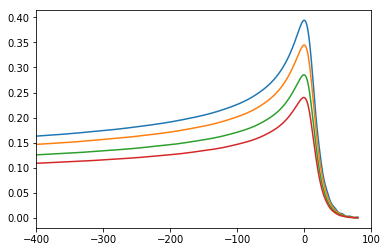

In [8]:
plt.plot(nrdata_for_testing[0].times, nrdata_for_testing[0].amp)
plt.plot(nrdata_for_testing[1].times, nrdata_for_testing[1].amp)
plt.plot(nrdata_for_testing[2].times, nrdata_for_testing[2].amp)
plt.plot(nrdata_for_testing[3].times, nrdata_for_testing[3].amp)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(-400 , 100)

In [9]:
# define a new time sampling - non-uniform
# two different regions of uniformity

In [10]:
nr0=nrdata_for_testing[0]

In [11]:
nr0.times[0]

-600.0

In [12]:
# reg1 = np.linspace(nrdata_for_testing[0].t1, -100, 300)
# reg2 = np.linspace(reg1[-1], nrdata_for_testing[0].t2, 701)

In [13]:
reg1 = np.linspace(nrdata_for_testing[0].t1, -100, 500)
reg2 = np.linspace(reg1[-1], nrdata_for_testing[0].t2, 501)

In [14]:
# reg1 = np.linspace(nrdata_for_testing[0].t1, -100, 50)
# reg2 = np.linspace(reg1[-1], nrdata_for_testing[0].t2, 50)

In [15]:
new_times = np.concatenate((reg1[:-1], reg2))

In [16]:
new_times.shape

(1000,)

In [500]:
# for training
nrdata = [SingleModeNRWaveform(nrfile, ell, mm, npts_time,t1=t1,t2=t2) for nrfile in nrfiles]

In [597]:
npts_reg1=400
npts_reg2=200

In [598]:
for i in range(len(nrdata)):
    reg1 = np.linspace(nrdata[i].t1, -50, npts_reg1)
    reg2 = np.linspace(reg1[-1], nrdata[i].t2, npts_reg2)
    new_times = np.concatenate((reg1[:-1], reg2))
    nrdata[i].resample_data(new_times)

(-200, 100)

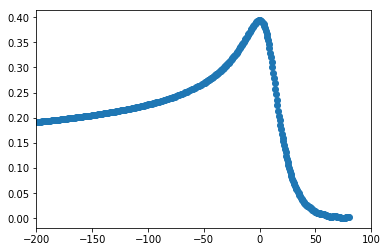

In [599]:
plt.figure()
plt.plot(nrdata[0].times, nrdata[0].amp, 'o')
plt.xlim(-200, 100)

In [600]:
x_train=nu.prepare_x_train_2d_data_for_neural_net(nrdata)

print(x_train)
print(x_train.shape)


[[-600.            0.99999999]
 [-598.62155388    0.99999999]
 [-597.24310777    0.99999999]
 ...
 [  78.69346734    3.9999874 ]
 [  79.34673367    3.9999874 ]
 [  80.            3.9999874 ]]
(2396, 2)


In [601]:
np.max(nrdata[0].phi)

-291.715620636887

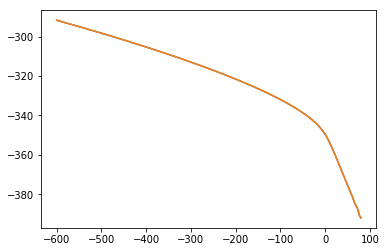

In [602]:
plt.plot(nrdata[0].times, nrdata[0].phi)
plt.plot(nrdata_for_testing[0].times, nrdata_for_testing[0].phi)

In [603]:
def my_prepare_y_train_2d_data_for_neural_net(dim1_data, data_attribute, scaling_method, centre_method=None):
    y_train = None

    for i in range(len(dim1_data)):
        if scaling_method == 'eta-amp':
            scale = getattr(dim1_data[i], 'eta')
        elif scaling_method == 'eta-phase':
            scale = getattr(dim1_data[i], 'eta')**-1
        elif scaling_method == 'eta-phase-and-max-first':
            scale1 = np.max(getattr(dim1_data[0], data_attribute))
            scale2 = getattr(dim1_data[i], 'eta')**0
            scale3 = np.max(getattr(dim1_data[i], data_attribute))
            scale = scale1*scale2*scale3
        elif scaling_method == 'maximum_of_first':
            scale = -np.max(getattr(dim1_data[0], data_attribute))
        elif scaling_method == 'maximum_of_each':
            scale = np.max(getattr(dim1_data[i], data_attribute))
        elif scaling_method is None:
            scale = 1.

        if centre_method == 'subtract_last':
            centre = getattr(dim1_data[i], data_attribute)[-1]
        elif centre_method is None:
            centre = 0.

        print scale
            
        if y_train is None:
            y_data = copy.copy(getattr(dim1_data[i], data_attribute))
            y_data -= centre
#             y_data /= scale
#             scale = np.max(y_data)
            scale = getattr(dim1_data[i], 'eta')*600
            y_data /= scale
            y_train = y_data
        else:
            y_data = copy.copy(getattr(dim1_data[i], data_attribute))
            y_data -= centre
#             y_data /= scale
#             scale = np.max(y_data)
            scale = getattr(dim1_data[i], 'eta')*600
            y_data /= scale
            y_train = np.row_stack((y_train, y_data))

    y_train = y_train.reshape( dim1_data[0].npts * len(dim1_data) )

    return y_train

In [604]:
# scaling_method='eta'
# scaling_method='eta-amp'
# scaling_method='eta-phase-and-max-first'
# scaling_method='eta-phase'
# scaling_method='maximum_of_first'
# scaling_method='maximum_of_each'
scaling_method=None

In [605]:
centre_method='subtract_last'
# centre_method=None

In [606]:
#TODO: Need to make it easier to scale the data
#TODO: need to implement a centring of the data

# data_attribute='amp'
data_attribute='phi'

y_train=my_prepare_y_train_2d_data_for_neural_net(nrdata,
    data_attribute=data_attribute,
    scaling_method=scaling_method,
    centre_method=centre_method)

y_no_scale=my_prepare_y_train_2d_data_for_neural_net(nrdata,
    data_attribute=data_attribute,
    scaling_method=None,
    centre_method=None)

# y_train=nu.prepare_y_train_2d_data_for_neural_net(nrdata,
#     data_attribute=data_attribute,
#     scaling_method=scaling_method,
#     centre_method=centre_method)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [607]:
print(y_train)
print(y_train.shape)

[0.66859646 0.66801184 0.66742679 ... 0.00805385 0.00418677 0.        ]
(2396,)


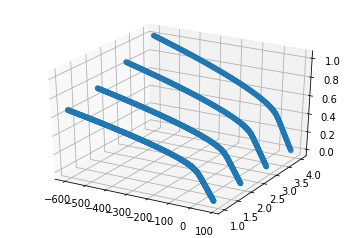

In [608]:
# plot the input data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train)
# ax.scatter(x_train[:,0], x_train[:,1], y_no_scale)
plt.show()

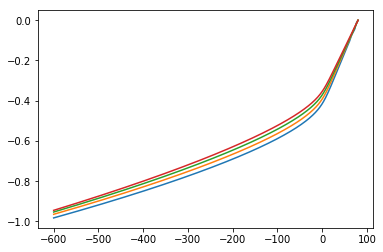

In [609]:
plt.figure()
plt.plot(nrdata[0].times, (nrdata[0].phi-nrdata[0].phi[-1])/nrdata[0].phi[0]*(1./0.35))
plt.plot(nrdata[1].times, (nrdata[1].phi-nrdata[1].phi[-1])/nrdata[0].phi[0]*(1./0.35))
plt.plot(nrdata[2].times, (nrdata[2].phi-nrdata[2].phi[-1])/nrdata[0].phi[0]*(1./0.35))
plt.plot(nrdata[3].times, (nrdata[3].phi-nrdata[3].phi[-1])/nrdata[0].phi[0]*(1./0.35))

In [610]:
(nrdata[0].phi-nrdata[0].phi[-1])[0]

100.28946842144984

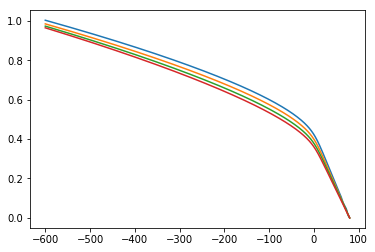

In [611]:
plt.figure()
plt.plot(nrdata[0].times, (nrdata[0].phi-nrdata[0].phi[-1])/100)
plt.plot(nrdata[1].times, (nrdata[1].phi-nrdata[1].phi[-1])/100)
plt.plot(nrdata[2].times, (nrdata[2].phi-nrdata[2].phi[-1])/100)
plt.plot(nrdata[3].times, (nrdata[3].phi-nrdata[3].phi[-1])/100)

In [612]:
1 = 0.35*A

SyntaxError: can't assign to literal (<ipython-input-612-82a3c9cf0196>, line 1)

In [613]:
1/0.35

2.857142857142857

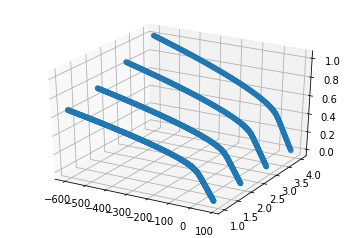

In [614]:
# plot the input data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train)
plt.show()

In [615]:
# network_topology='default'
network_topology='ed_style'

In [616]:
act='softplus'
# act='elu'
# act='relu'
model = nu.train_network(x_train, y_train, act, epochs=500, network_topology=network_topology, metrics=['accuracy'])

Epoch 1/500
2396/2396 [==============================] - 1s 240us/step - loss: 0.1422 - acc: 0.0017
Epoch 2/500
2396/2396 [==============================] - 0s 55us/step - loss: 0.0066 - acc: 0.0017
Epoch 3/500
2396/2396 [==============================] - 0s 46us/step - loss: 0.0063 - acc: 0.0017
Epoch 4/500
2396/2396 [==============================] - 0s 53us/step - loss: 0.0057 - acc: 0.0017
Epoch 5/500
2396/2396 [==============================] - 0s 50us/step - loss: 0.0041 - acc: 0.0017
Epoch 6/500
2396/2396 [==============================] - 0s 51us/step - loss: 0.0023 - acc: 0.0017
Epoch 7/500
2396/2396 [==============================] - 0s 49us/step - loss: 0.0011 - acc: 0.0017
Epoch 8/500
2396/2396 [==============================] - 0s 56us/step - loss: 0.0015 - acc: 0.0017 
Epoch 9/500
2396/2396 [==============================] - 0s 46us/step - loss: 9.0379e-04 - acc: 0.0017
Epoch 10/500
2396/2396 [==============================] - 0s 46us/step - loss: 7.8728e-04 - acc: 0.0017

2396/2396 [==============================] - 0s 48us/step - loss: 6.6305e-05 - acc: 0.0017
Epoch 81/500
2396/2396 [==============================] - 0s 49us/step - loss: 2.0256e-05 - acc: 0.0017
Epoch 82/500
2396/2396 [==============================] - 0s 48us/step - loss: 5.9227e-05 - acc: 0.0017
Epoch 83/500
2396/2396 [==============================] - 0s 47us/step - loss: 5.9131e-05 - acc: 0.0017
Epoch 84/500
2396/2396 [==============================] - 0s 47us/step - loss: 1.3601e-04 - acc: 0.0017
Epoch 85/500
2396/2396 [==============================] - 0s 47us/step - loss: 2.0950e-04 - acc: 0.0017
Epoch 86/500
2396/2396 [==============================] - 0s 47us/step - loss: 5.5461e-05 - acc: 0.0017
Epoch 87/500
2396/2396 [==============================] - 0s 51us/step - loss: 2.0217e-05 - acc: 0.0017
Epoch 88/500
2396/2396 [==============================] - 0s 50us/step - loss: 2.6555e-05 - acc: 0.0017
Epoch 89/500
2396/2396 [==============================] - 0s 48us/step - loss

2396/2396 [==============================] - 0s 48us/step - loss: 5.8293e-05 - acc: 0.0017
Epoch 159/500
2396/2396 [==============================] - 0s 47us/step - loss: 3.5562e-05 - acc: 0.0017
Epoch 160/500
2396/2396 [==============================] - 0s 49us/step - loss: 1.9961e-05 - acc: 0.0017
Epoch 161/500
2396/2396 [==============================] - 0s 47us/step - loss: 2.1495e-05 - acc: 0.0017
Epoch 162/500
2396/2396 [==============================] - 0s 48us/step - loss: 3.6672e-05 - acc: 0.0017
Epoch 163/500
2396/2396 [==============================] - 0s 47us/step - loss: 4.2579e-04 - acc: 0.0017
Epoch 164/500
2396/2396 [==============================] - 0s 48us/step - loss: 4.0656e-05 - acc: 0.0017
Epoch 165/500
2396/2396 [==============================] - 0s 47us/step - loss: 8.9298e-06 - acc: 0.0017
Epoch 166/500
2396/2396 [==============================] - 0s 46us/step - loss: 4.7578e-06 - acc: 0.0017
Epoch 167/500
2396/2396 [==============================] - 0s 48us/st

2396/2396 [==============================] - 0s 48us/step - loss: 5.6875e-06 - acc: 0.0017
Epoch 237/500
2396/2396 [==============================] - 0s 50us/step - loss: 1.6768e-05 - acc: 0.0017
Epoch 238/500
2396/2396 [==============================] - 0s 46us/step - loss: 4.9383e-06 - acc: 0.0017
Epoch 239/500
2396/2396 [==============================] - 0s 47us/step - loss: 7.9694e-06 - acc: 0.0017
Epoch 240/500
2396/2396 [==============================] - 0s 48us/step - loss: 5.9767e-06 - acc: 0.0017
Epoch 241/500
2396/2396 [==============================] - 0s 47us/step - loss: 1.4974e-05 - acc: 0.0017
Epoch 242/500
2396/2396 [==============================] - 0s 47us/step - loss: 1.0225e-05 - acc: 0.0017
Epoch 243/500
2396/2396 [==============================] - 0s 47us/step - loss: 5.7327e-06 - acc: 0.0017
Epoch 244/500
2396/2396 [==============================] - 0s 47us/step - loss: 5.5890e-06 - acc: 0.0017
Epoch 245/500
2396/2396 [==============================] - 0s 48us/st

2396/2396 [==============================] - 0s 48us/step - loss: 7.2480e-05 - acc: 0.0017
Epoch 315/500
2396/2396 [==============================] - 0s 47us/step - loss: 2.6588e-05 - acc: 0.0017
Epoch 316/500
2396/2396 [==============================] - 0s 48us/step - loss: 2.0344e-04 - acc: 0.0017
Epoch 317/500
2396/2396 [==============================] - 0s 49us/step - loss: 7.3259e-05 - acc: 0.0017
Epoch 318/500
2396/2396 [==============================] - 0s 49us/step - loss: 7.2137e-06 - acc: 0.0017
Epoch 319/500
2396/2396 [==============================] - 0s 52us/step - loss: 4.3689e-06 - acc: 0.0017
Epoch 320/500
2396/2396 [==============================] - 0s 58us/step - loss: 3.3655e-06 - acc: 0.0017
Epoch 321/500
2396/2396 [==============================] - 0s 72us/step - loss: 1.2382e-05 - acc: 0.0017
Epoch 322/500
2396/2396 [==============================] - 0s 72us/step - loss: 1.9469e-05 - acc: 0.0017
Epoch 323/500
2396/2396 [==============================] - 0s 57us/st

2396/2396 [==============================] - 0s 48us/step - loss: 2.2262e-05 - acc: 0.0017
Epoch 393/500
2396/2396 [==============================] - 0s 47us/step - loss: 3.7633e-06 - acc: 0.0017
Epoch 394/500
2396/2396 [==============================] - 0s 44us/step - loss: 1.4298e-05 - acc: 0.0017
Epoch 395/500
2396/2396 [==============================] - 0s 48us/step - loss: 2.0665e-05 - acc: 0.0017
Epoch 396/500
2396/2396 [==============================] - 0s 46us/step - loss: 1.1277e-05 - acc: 0.0017
Epoch 397/500
2396/2396 [==============================] - 0s 48us/step - loss: 8.5603e-06 - acc: 0.0017
Epoch 398/500
2396/2396 [==============================] - 0s 48us/step - loss: 1.4293e-05 - acc: 0.0017
Epoch 399/500
2396/2396 [==============================] - 0s 49us/step - loss: 5.6443e-06 - acc: 0.0017
Epoch 400/500
2396/2396 [==============================] - 0s 49us/step - loss: 6.8746e-06 - acc: 0.0017
Epoch 401/500
2396/2396 [==============================] - 0s 50us/st

2396/2396 [==============================] - 0s 47us/step - loss: 2.0721e-04 - acc: 0.0017
Epoch 471/500
2396/2396 [==============================] - 0s 49us/step - loss: 5.0132e-05 - acc: 0.0017
Epoch 472/500
2396/2396 [==============================] - 0s 47us/step - loss: 7.4754e-06 - acc: 0.0017
Epoch 473/500
2396/2396 [==============================] - 0s 48us/step - loss: 4.1414e-06 - acc: 0.0017
Epoch 474/500
2396/2396 [==============================] - 0s 49us/step - loss: 3.0787e-06 - acc: 0.0017
Epoch 475/500
2396/2396 [==============================] - 0s 46us/step - loss: 4.6872e-06 - acc: 0.0017
Epoch 476/500
2396/2396 [==============================] - 0s 47us/step - loss: 4.6761e-06 - acc: 0.0017
Epoch 477/500
2396/2396 [==============================] - 0s 45us/step - loss: 5.8492e-06 - acc: 0.0017
Epoch 478/500
2396/2396 [==============================] - 0s 45us/step - loss: 1.2196e-05 - acc: 0.0017
Epoch 479/500
2396/2396 [==============================] - 0s 46us/st

### callbacks

In [617]:
model.losses

[]

In [618]:
model.metrics_names

['loss', 'acc']

In [619]:
model.metrics

['accuracy']

In [620]:
model.metrics_tensors

[<tf.Tensor 'metrics_11/acc/Mean_1:0' shape=() dtype=float32>]

In [621]:
model.model.history.history.keys()

['acc', 'loss']

In [622]:
np.min(model.model.history.history['loss'])

2.261170991247379e-06

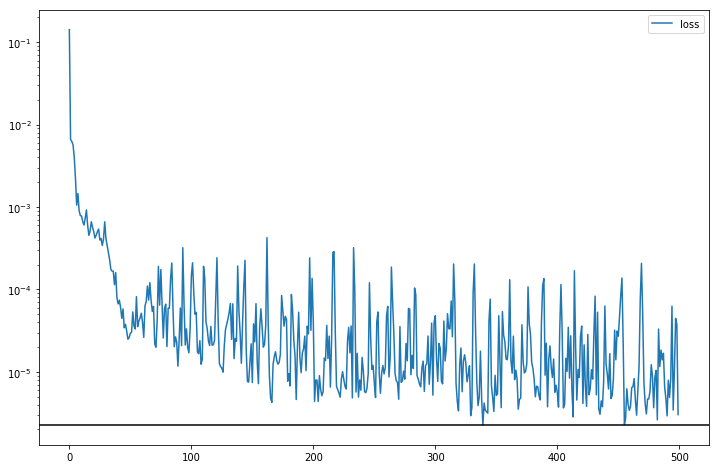

In [623]:
plt.figure(figsize=(12,8))
plt.plot(model.model.history.epoch, model.model.history.history['loss'], label='loss')
plt.axhline(np.min(model.model.history.history['loss']), color='k')
plt.legend()
plt.yscale('log')

### compare model to data

In [624]:
y_predict = model.predict(x_train)

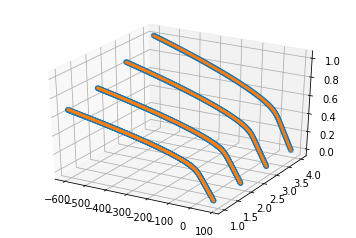

In [625]:
# plot the input data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train, color='C0',s=20)
ax.scatter(x_train[:,0], x_train[:,1], y_predict, color='C1',s=3)
plt.show()

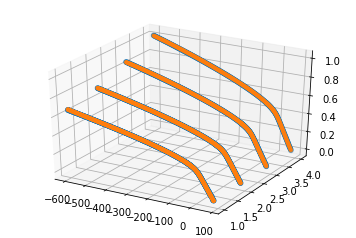

In [626]:
# plot the input data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train, color='C0',s=20)
ax.scatter(x_train[:,0], x_train[:,1], y_predict, color='C1',s=10)
plt.show()

In [627]:
x_train.shape

(2396, 2)

In [628]:
x_train[:,1]

array([0.99999999, 0.99999999, 0.99999999, ..., 3.9999874 , 3.9999874 ,
       3.9999874 ])

In [629]:
npts_time

1000

In [630]:
npts_time_new = len(nrdata[0].times)

In [631]:
npts_time_new

599

In [632]:
times = x_train[:npts_time_new,0]
qlist = x_train[:npts_time_new,1]

In [633]:
X = np.column_stack((times, qlist))

In [634]:
p1 = model.predict(X)

In [635]:
# nrdata = [SingleModeNRWaveform(nrfile, ell, mm, npts_time,t1=t1,t2=t2) for nrfile in nrfiles]

In [636]:
times.shape

(599,)

In [637]:
p1.shape

(599, 1)

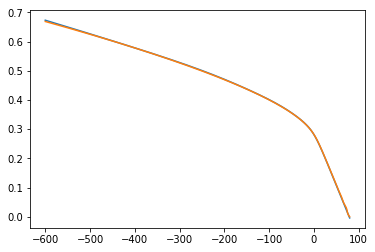

In [638]:
plt.figure()
plt.plot(times, p1)
# sc=(nrdata[0].phi-nrdata[0].phi[-1])[0]
sc=nrdata[0].eta*600
plt.plot(times, (nrdata[0].phi-nrdata[0].phi[-1])/sc)

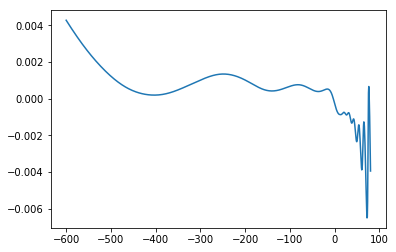

In [639]:
plt.figure()
# sc=(nrdata[0].phi-nrdata[0].phi[-1])[0]
sc=nrdata[0].eta*600
nrp1=(nrdata[0].phi-nrdata[0].phi[-1])/sc
plt.plot(times, p1[:,0]-nrp1)

In [640]:
def compare_model_to_data(idx, nrdata, model):
    
    times_points = len(nrdata[idx].times)
    
    q = nrdata[idx].q
    
    times = x_train[:times_points,0]
    qlist = np.zeros(len(times)) + q
    
    X = np.column_stack((times, qlist))
    
    p1 = model.predict(X)[:,0]

#     sc=(nrdata[idx].phi-nrdata[idx].phi[-1])[0]
    sc=nrdata[idx].eta*600
    nrpi=(nrdata[idx].phi-nrdata[idx].phi[-1])/sc
    
    max_diff = np.max(np.abs(nrpi-p1))
    mean_diff = np.mean(nrpi-p1)
    
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    
    axes[0].plot(times, p1)
    axes[0].plot(times, nrpi)
    
    axes[1].plot(times, nrpi-p1)
    axes[1].axhline(-max_diff, color='k', ls='--')
    axes[1].axhline(max_diff, color='k', ls='--')
    axes[1].axhline(mean_diff, color='k', ls='-.')
    axes[1].set_title("max diff = {0:.4}".format(max_diff))

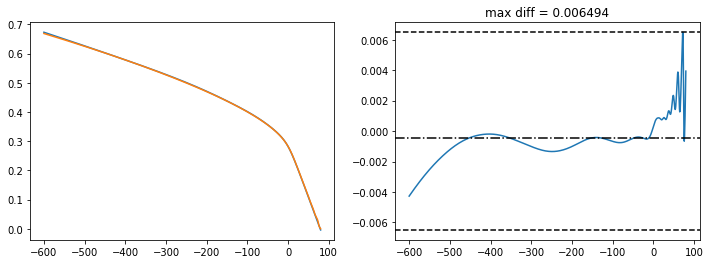

In [641]:
compare_model_to_data(0, nrdata, model)

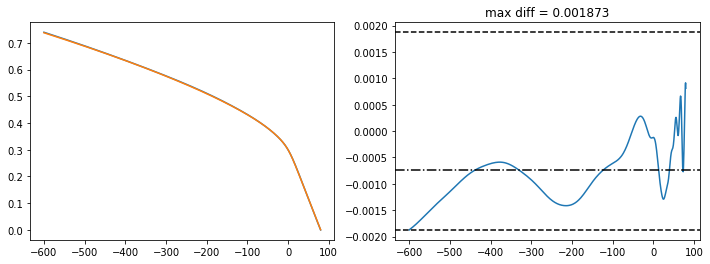

In [642]:
compare_model_to_data(1, nrdata, model)

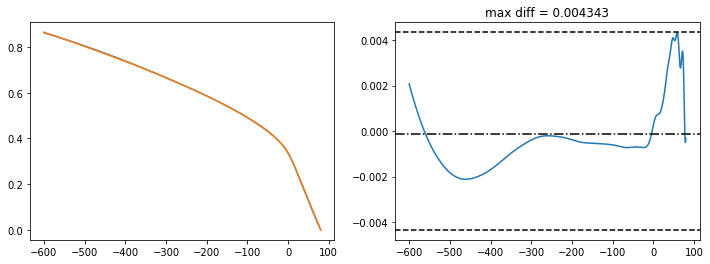

In [643]:
compare_model_to_data(2, nrdata, model)

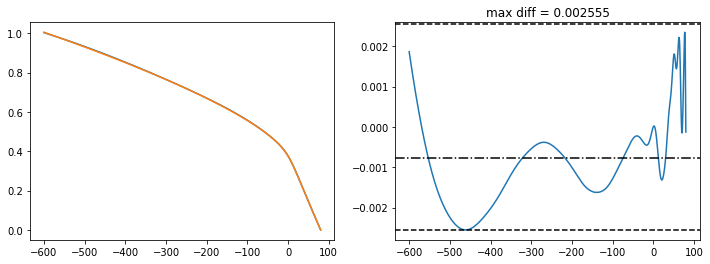

In [644]:
compare_model_to_data(3, nrdata, model)